In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
import pandas as pd
import tables
import umap.plot
import scipy
from  sklearn.cluster import KMeans
import hdbscan
# 


DATA_DIR             = "/home/camata/git/cgp-grn/data/"
FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CELL_METADATA     = os.path.join(DATA_DIR,"metadata.csv")



2022-10-18 12:44:21.817344: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
cite_train = pd.read_hdf(FP_CITE_TRAIN_INPUTS,start=0, index_col=0)


In [17]:
cell_names = []
drop_genes = []
dict_var = {}
for gene in cite_train.columns:
    variance  = np.var(cite_train[gene])
    if variance==0:
        drop_genes.append(gene)
    else:
        dict_var[gene] = variance

dfv = pd.DataFrame(data=dict_var, index=['variance'])
dfv.T.to_hdf('genes_variance.h5',key='variance');    

        
print("Number of genes with no variances", len(drop_genes))

# remove genes with no variances
dropped = cite_train.drop(columns=drop_genes)
cell_names = dropped.T.columns
print("Number of cells: %d" %(dropped.shape[0]))
print("Number of genes: %d" %(dropped.shape[1]))

# dimension reduction using UMAP
print("Running umap...")
mapper = umap.UMAP( n_neighbors=50,min_dist=0.0,n_components=2,n_epochs=30,low_memory=True).fit_transform(dropped.values)


Number of genes with no variances 449
Number of cells: 70988
Number of genes: 21601
Running umap...


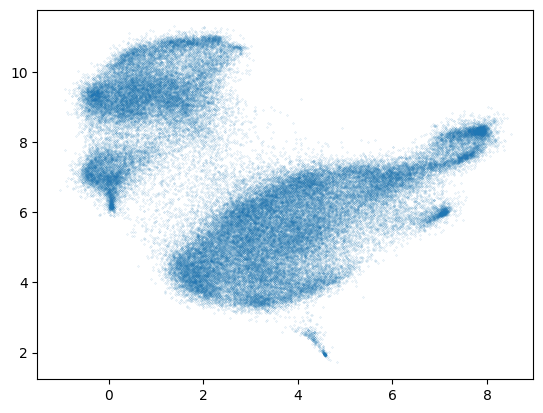

In [28]:
plt.scatter(mapper[:, 0], mapper[:, 1],s=0.025,alpha=0.5)
plt.savefig('umap_scatter.png')
plt.show()

In [29]:
import hdbscan

hdbscan_labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(mapper)


kmeans_labels = KMeans(n_clusters=3, random_state=42).fit_predict(mapper) ##min clusters depende dos dados, pq?



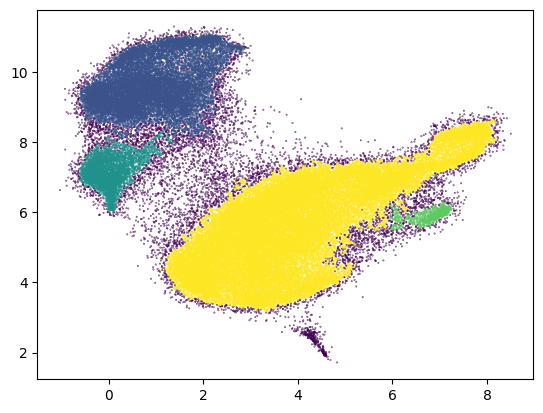

In [34]:
#clustered = (kmeans_labels >= 0)
clustered = (hdbscan_labels >= 0)
labels = hdbscan_labels

#
plt.scatter(mapper[:, 0],
            mapper[:, 1],
            c=labels,
            s=0.1,
            cmap='viridis')
plt.savefig("cluster.png")
plt.show()

In [35]:
import scanpy as sc
import scFates as scf


In [42]:
adata=sc.AnnData(mapper,basis='')
scf.tl.tree(adata,method="ppt",Nodes=200,use_rep="palantir",
            device="cpu",seed=1,ppt_lambda=100,ppt_sigma=0.025,ppt_nsteps=200)

inferring a principal tree --> parameters used 
    200 principal points, sigma = 0.025, lambda = 100, metric = euclidean
    fitting:   3%|▎         | 6/200 [00:02<01:16,  2.52it/s]
    converged
    more than 30 tips detected!
    finished (0:00:02) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


In [43]:
scf.pl.graph(adata)

Exception: No basis found in adata (tSNE, UMAP or FA2), please specify basis

Number of clusters: 3


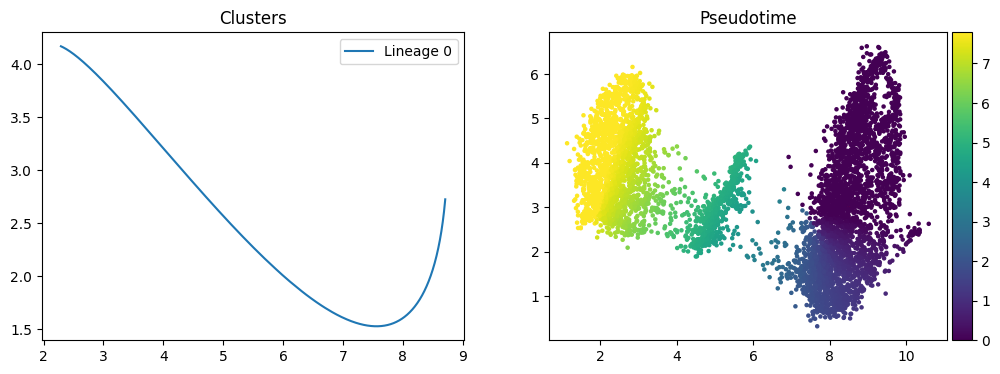

In [19]:

print("Number of clusters: %d" %(slingshot.num_clusters))

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].set_title('Clusters')
axes[1].set_title('Pseudotime')
slingshot.plotter.curves(axes[0], slingshot.curves)
slingshot.plotter.clusters(axes[1], color_mode='pseudotime', s=5)